In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col
import matplotlib.pyplot as plt


In [5]:
spark = SparkSession.builder.appName("GenderInequality").getOrCreate()


In [6]:
gender_inequality_data = spark.read.csv("Gender_Inequality_Index.csv", header=True, inferSchema=True)


In [7]:
# Display the first set of rows from the dataset

In [8]:
gender_inequality_data.show(30)

+--------------------+-----------------+-----+----+------------------+---------------------+----------------+----------------+----------------+--------------+--------------+
|             Country|Human_development|  GII|Rank|Maternal_mortality|Adolescent_birth_rate|Seats_parliament|F_secondary_educ|M_secondary_educ|F_Labour_force|M_Labour_force|
+--------------------+-----------------+-----+----+------------------+---------------------+----------------+----------------+----------------+--------------+--------------+
|         Switzerland|        Very high|0.018|   3|                 5|                  2.2|            39.8|            96.9|            97.5|          61.7|          72.7|
|              Norway|        Very high|0.016|   2|                 2|                  2.3|            45.0|            99.1|            99.3|          60.3|          72.0|
|             Iceland|        Very high|0.043|   8|                 4|                  5.4|            47.6|            99.8|    

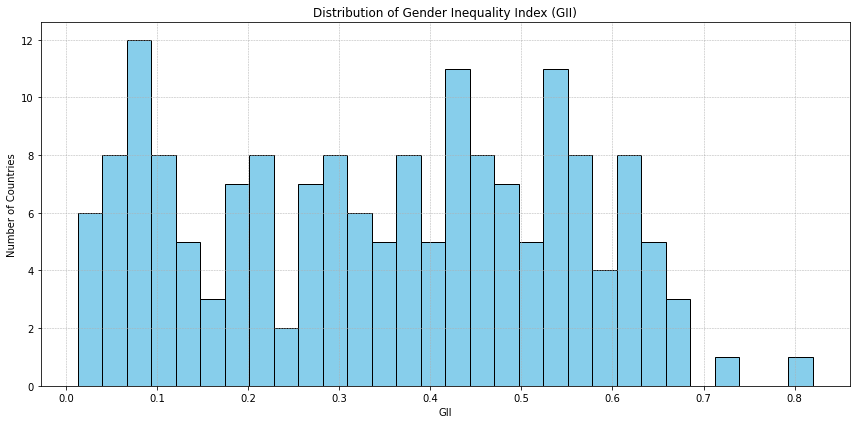

In [9]:
# GII 
gii_values = gender_inequality_data.select("GII").na.drop().rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(12, 6))
plt.hist(gii_values, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Gender Inequality Index (GII)')
plt.xlabel('GII')
plt.ylabel('Number of Countries')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

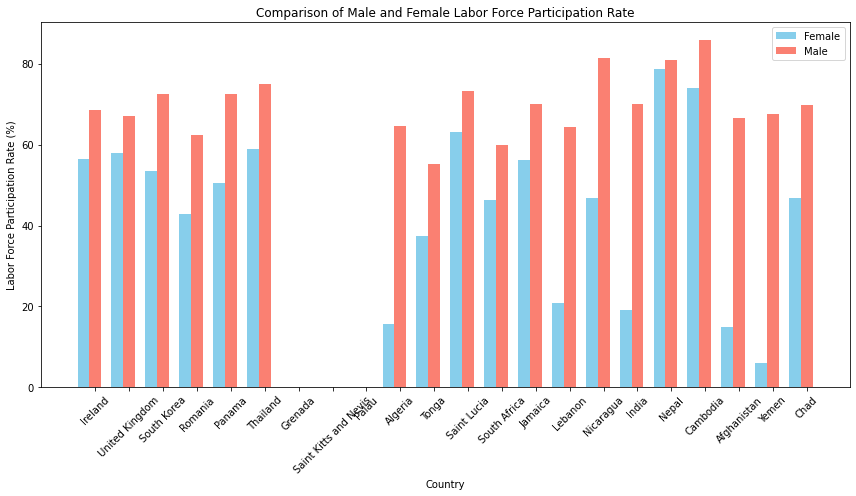

In [10]:
# 10 random countries
countries_sample = gender_inequality_data.sample(False, 0.1, 42).toPandas()

plt.figure(figsize=(12, 7))
bar_width = 0.35
index = range(len(countries_sample))
plt.bar(index, countries_sample['F_Labour_force'], bar_width, label='Female', color='skyblue')
plt.bar([i + bar_width for i in index], countries_sample['M_Labour_force'], bar_width, label='Male', color='salmon')
plt.xlabel('Country')
plt.ylabel('Labor Force Participation Rate (%)')
plt.title('Comparison of Male and Female Labor Force Participation Rate')
plt.xticks([i + bar_width for i in index], countries_sample['Country'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

<Figure size 864x504 with 0 Axes>

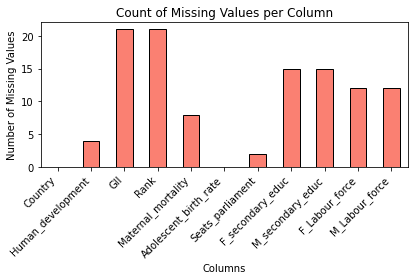

In [11]:
# conculate the missing value
missing_values_count = gender_inequality_data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in gender_inequality_data.columns]).toPandas().transpose()

plt.figure(figsize=(12, 7))
missing_values_count.plot(kind='bar', color='salmon', edgecolor='black', legend=None)
plt.title('Count of Missing Values per Column')
plt.ylabel('Number of Missing Values')
plt.xlabel('Columns')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [12]:
# 转换 "Human_development" 列为数值序数值
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

ordinal_mapping = {'Very high': 4, 'High': 3, 'Medium': 2, 'Low': 1}
ordinal_udf = udf(lambda x: ordinal_mapping.get(x), IntegerType())
gender_inequality_data = gender_inequality_data.withColumn('HDI_ordinal', ordinal_udf(col('Human_development')))

In [13]:
from pyspark.sql.types import DoubleType, FloatType, IntegerType

# 获取所有数值类型列
numeric_columns = [field.name for field in gender_inequality_data.schema.fields if isinstance(field.dataType, (DoubleType, FloatType, IntegerType))]

# 从数值类型列中排除 'Rank' 和 'HDI_ordinal'
columns_to_correlate = [column for column in numeric_columns if column != 'Rank' and column != 'HDI_ordinal']

correlation_with_HDI_ordinal = []

for column in columns_to_correlate:
    correlation_value = gender_inequality_data.stat.corr(column, 'HDI_ordinal')
    correlation_with_HDI_ordinal.append((column, correlation_value))
    
correlation_with_HDI_ordinal = sorted(correlation_with_HDI_ordinal, key=lambda x: x[1])


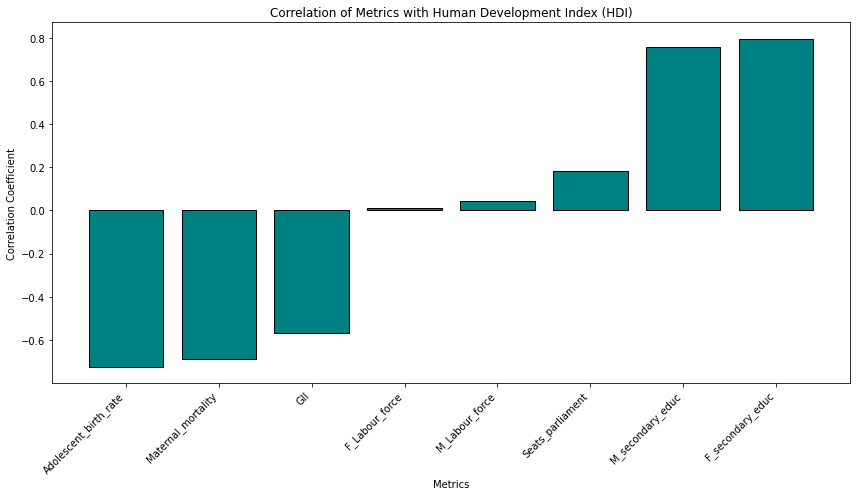

In [14]:
# 创建条形图以可视化相关性
columns, correlation_values = zip(*correlation_with_HDI_ordinal)

plt.figure(figsize=(12, 7))
plt.bar(columns, correlation_values, color='teal', edgecolor='black')
plt.title('Correlation of Metrics with Human Development Index (HDI)')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Metrics')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [15]:

from pyspark.sql.functions import mean, col, when, count, isnan, udf, initcap
from pyspark.sql.window import Window
import seaborn as sns
# 1. Handling missing values for numeric columns
numerical_columns = [f.name for f in gender_inequality_data.schema.fields if isinstance(f.dataType, (FloatType, DoubleType))]

for column in numerical_columns:
    for level in ['Very high', 'High', 'Medium', 'Low']:
        mean_value = gender_inequality_data.filter(col("Human_development") == level).agg(mean(column)).first()[0]
        gender_inequality_data = gender_inequality_data.withColumn(column, when((col("Human_development") == level) & (col(column).isNull()), mean_value).otherwise(col(column)))


In [16]:
# 2. Identify and handle outliers
original_data_pd = gender_inequality_data.select(numerical_columns).toPandas()
for column in numerical_columns:
    quantiles = gender_inequality_data.approxQuantile(column, [0.25, 0.75], 0.05)
    Q1 = quantiles[0]
    Q3 = quantiles[1]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    mean_value = gender_inequality_data.agg(mean(column)).first()[0]
    gender_inequality_data = gender_inequality_data.withColumn(column, when((col(column) < lower_bound) | (col(column) > upper_bound), mean_value).otherwise(col(column)))


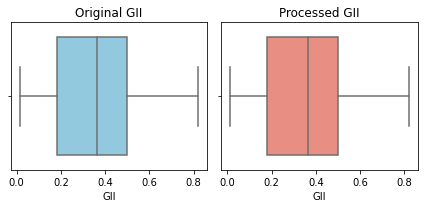

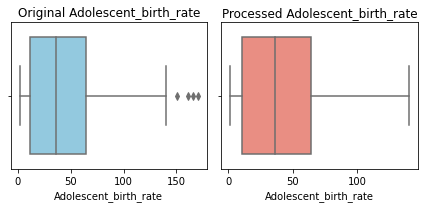

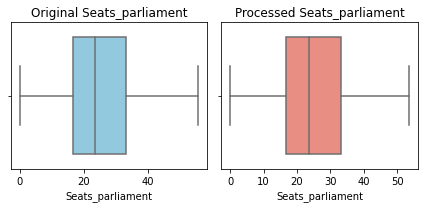

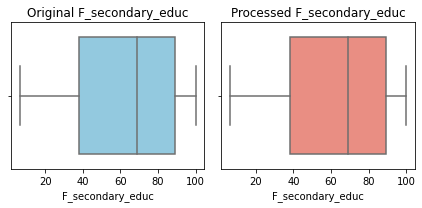

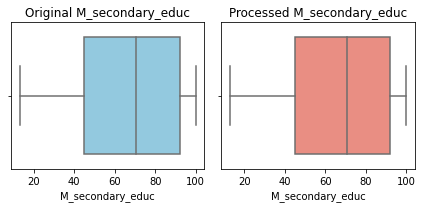

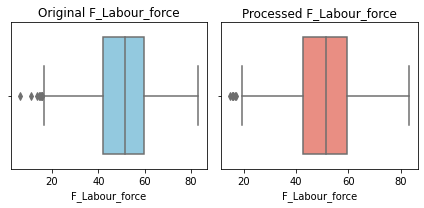

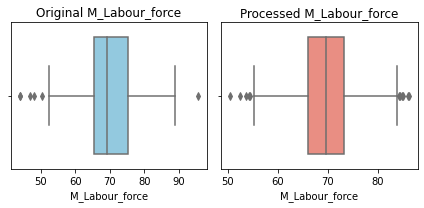

In [17]:
# Convert processed data to Pandas DataFrame for visualization
processed_data_pd = gender_inequality_data.select(numerical_columns).toPandas()

# Plot the data before and after processing
for column in numerical_columns:
    plt.figure(figsize=(6, 3))
    
    # original_data_pd
    plt.subplot(1, 2, 1)
    sns.boxplot(x=original_data_pd[column], color='skyblue')
    plt.title(f'Original {column}')
    
    # processed_data_pd
    plt.subplot(1, 2, 2)
    sns.boxplot(x=processed_data_pd[column], color='salmon')
    plt.title(f'Processed {column}')
    
    plt.tight_layout()
    plt.show()


In [18]:
# 3. 处理数据不一致性
gender_inequality_data = gender_inequality_data.withColumn("Country", initcap(col("Country")))

# 构造新的特征
gender_inequality_data = gender_inequality_data.withColumn("Education_Disparity_Ratio", col("M_secondary_educ") / col("F_secondary_educ"))
gender_inequality_data = gender_inequality_data.withColumn("Workforce_Disparity_Ratio", col("M_Labour_force") / col("F_Labour_force"))

# 将 PySpark DataFrame 转换为 Pandas DataFrame 进行可视化
gender_inequality_data_pd = gender_inequality_data.toPandas()
print(gender_inequality_data.toPandas().head(10))


       Country Human_development       GII  Rank  Maternal_mortality  \
0  Switzerland         Very high  0.018000   3.0                 5.0   
1       Norway         Very high  0.016000   2.0                 2.0   
2      Iceland         Very high  0.043000   8.0                 4.0   
3    Hong Kong         Very high  0.147032   NaN                 NaN   
4    Australia         Very high  0.073000  19.0                 6.0   
5      Denmark         Very high  0.013000   1.0                 4.0   
6       Sweden         Very high  0.023000   4.0                 4.0   
7      Ireland         Very high  0.074000  21.0                 5.0   
8      Germany         Very high  0.073000  19.0                 7.0   
9  Netherlands         Very high  0.025000   5.0                 5.0   

   Adolescent_birth_rate  Seats_parliament  F_secondary_educ  \
0                    2.2         39.800000              96.9   
1                    2.3         45.000000              99.1   
2              

In [19]:
# 设置 Seaborn 样式
sns.set_style("whitegrid")

# Plot the distribution of new features
plt.figure(figsize=(14, 6))


<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

Text(0, 0.5, 'Number of Countries')

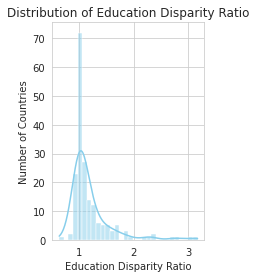

In [20]:
# Educational difference ratio distribution
plt.subplot(1, 2, 1)
sns.histplot(gender_inequality_data_pd['Education_Disparity_Ratio'], bins=30, color='skyblue', kde=True)
plt.title('Distribution of Education Disparity Ratio')
plt.xlabel('Education Disparity Ratio')
plt.ylabel('Number of Countries')

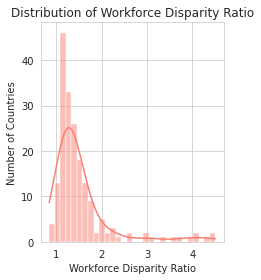

In [21]:
# Labor force difference ratio distribution
plt.subplot(1, 2, 2)
sns.histplot(gender_inequality_data_pd['Workforce_Disparity_Ratio'], bins=30, color='salmon', kde=True)
plt.title('Distribution of Workforce Disparity Ratio')
plt.xlabel('Workforce Disparity Ratio')
plt.ylabel('Number of Countries')

plt.tight_layout()
plt.show()

In [22]:
hdi_data = spark.read.csv("HDI-1997-2019.csv", header=True, inferSchema=True)
rate_data = spark.read.csv("rate_1997-2019.csv", header=True, inferSchema=True)
merged_data = hdi_data.join(rate_data, ["Country Name", "Year"], "outer")
merged_data.show(50)

+------------+--------+-----+------+------+----------+-----------+-----------+
|Country Name|    Year|  hdi|lfpr_f|lfpr_m|      se_f|       se_m|  seat_rate|
+------------+--------+-----+------+------+----------+-----------+-----------+
| Afghanistan|1997/1/1|0.323|14.954|76.262| 1.1829055| 6.44923533|       null|
| Afghanistan|1998/1/1|0.324|14.873|76.415|1.24442633|  6.5542821|       null|
| Afghanistan|1999/1/1|0.332|14.827|76.549|1.30594716| 6.65932888|       null|
| Afghanistan|2000/1/1|0.335|14.795|76.646|1.36746799| 6.76437565|       null|
| Afghanistan|2001/1/1|0.337|14.936|76.589|1.47649996| 7.18376694|       null|
| Afghanistan|2002/1/1|0.362|15.113|76.491|1.58553193| 7.60315823|       null|
| Afghanistan|2003/1/1|0.376|15.298|76.393| 1.6945639| 8.02254952|       null|
| Afghanistan|2004/1/1|0.392|15.475|76.332|1.80359587| 8.44194082|       null|
| Afghanistan|2005/1/1|  0.4|15.644|76.318|1.91262783| 8.86133211|25.92592593|
| Afghanistan|2006/1/1|0.409|15.455|76.422|1.8876540

In [23]:
# Convert 'Year' column to integer format:
from pyspark.sql.functions import mean, col, when, last, first, split
from pyspark.sql.window import Window


merged_data.select('Year').distinct().show()

split_col = split(merged_data['Year'], '/')

merged_data = merged_data.withColumn('Year', split_col.getItem(0).cast('int'))
# merged_data = merged_data.withColumn("Year", col("Year").cast("int"))


# Handle missing values using forward fill:
window_spec = Window.partitionBy("Country Name").orderBy("Year")

# Excluding the 'Country Name' and 'Year' columns from the forward and backward fill operations
columns_to_process = [column for column in merged_data.columns if column not in ["Country Name", "Year"]]

for column in columns_to_process:
    merged_data = merged_data.withColumn(column, when(col(column).isNotNull(), col(column)).otherwise(last(col(column), True).over(window_spec)))

# If there are still any missing values, we can backward fill:
for column in columns_to_process:
    merged_data = merged_data.withColumn(column, when(col(column).isNotNull(), col(column)).otherwise(first(col(column), True).over(window_spec)))

merged_data.show(50)

+--------+
|    Year|
+--------+
|2002/1/1|
|2009/1/1|
|2006/1/1|
|2013/1/1|
|2014/1/1|
|2012/1/1|
|2015/1/1|
|1999/1/1|
|2010/1/1|
|2016/1/1|
|2007/1/1|
|2018/1/1|
|2008/1/1|
|2000/1/1|
|2001/1/1|
|2005/1/1|
|1997/1/1|
|2003/1/1|
|1998/1/1|
|2019/1/1|
+--------+
only showing top 20 rows

+------------+----+-----+------+------+----------+-----------+-----------+
|Country Name|Year|  hdi|lfpr_f|lfpr_m|      se_f|       se_m|  seat_rate|
+------------+----+-----+------+------+----------+-----------+-----------+
| Afghanistan|1997|0.323|14.954|76.262| 1.1829055| 6.44923533|       null|
| Afghanistan|1998|0.324|14.873|76.415|1.24442633|  6.5542821|       null|
| Afghanistan|1999|0.332|14.827|76.549|1.30594716| 6.65932888|       null|
| Afghanistan|2000|0.335|14.795|76.646|1.36746799| 6.76437565|       null|
| Afghanistan|2001|0.337|14.936|76.589|1.47649996| 7.18376694|       null|
| Afghanistan|2002|0.362|15.113|76.491|1.58553193| 7.60315823|       null|
| Afghanistan|2003|0.376|15.298|76.

In [24]:
from pyspark.sql.functions import corr
import numpy as np

columns_to_correlate = ['hdi', 'lfpr_f', 'seat_rate', 'se_f']
correlations = {}

for column in columns_to_correlate:
    correlation_value = merged_data.stat.corr('hdi', column)
    correlations[column] = correlation_value

print(correlations)

{'hdi': 1.0, 'lfpr_f': -0.1582246958235357, 'seat_rate': 0.269853371547347, 'se_f': 0.6981282571135361}


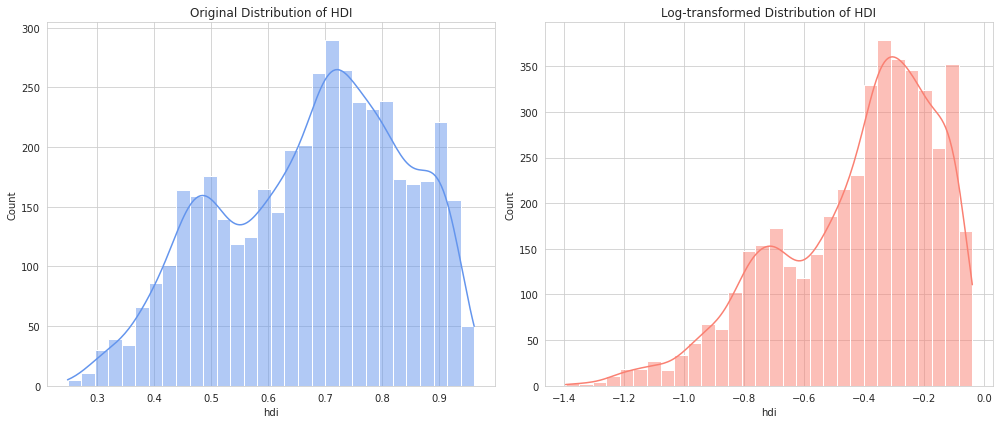

In [25]:
pdf = merged_data.select('hdi').toPandas()

# Visualization
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(pdf['hdi'], bins=30, color='cornflowerblue', kde=True)
plt.title('Original Distribution of HDI')

plt.subplot(1, 2, 2)
sns.histplot(pdf['hdi'].apply(np.log), bins=30, color='salmon', kde=True)
plt.title('Log-transformed Distribution of HDI')

plt.tight_layout()
plt.show()

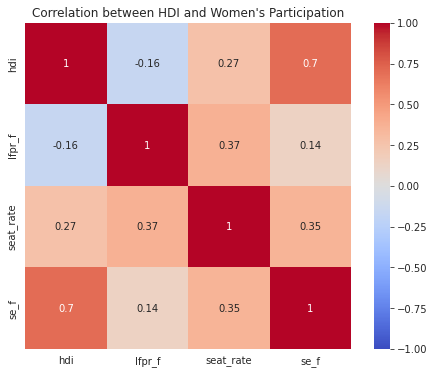

In [26]:
from pyspark.sql.functions import corr

columns_to_correlate = ['hdi', 'lfpr_f', 'seat_rate', 'se_f']
correlation_values_1 = []

for column1 in columns_to_correlate:
    row = []
    for column2 in columns_to_correlate:
        correlation_value = merged_data.stat.corr(column1, column2)
        row.append(correlation_value)
    correlation_values_1.append(row)

# Convert correlation_values to a pandas DataFrame for visualization
import pandas as pd
df_corr_1 = pd.DataFrame(correlation_values_1, columns=columns_to_correlate, index=columns_to_correlate)

# Heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(df_corr_1, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True)
plt.title('Correlation between HDI and Women\'s Participation')
plt.show()


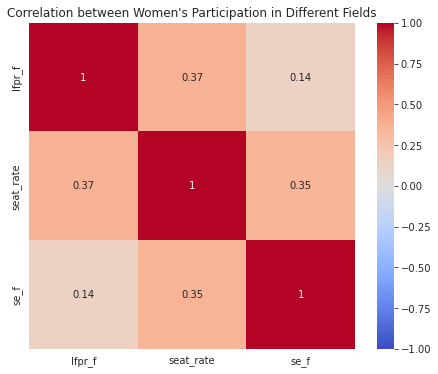

In [27]:
columns_to_correlate_2 = ['lfpr_f', 'seat_rate', 'se_f']
correlation_matrix = []
for column1 in columns_to_correlate_2:
    row = []
    for column2 in columns_to_correlate_2:
        correlation_value = merged_data.stat.corr(column1, column2)
        row.append(correlation_value)
    correlation_matrix.append(row)

df_corr_2 = pd.DataFrame(correlation_matrix, columns=columns_to_correlate_2, index=columns_to_correlate_2)

plt.figure(figsize=(8, 6))
sns.heatmap(df_corr_2, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True)
plt.title('Correlation between Women\'s Participation in Different Fields')
plt.show()


In [28]:
from pyspark.sql import functions as F

# 1. Aggregate the data by year
grouped_data = merged_data.groupBy('Year').agg(
    F.avg('hdi').alias('avg_hdi'),
    F.avg('lfpr_f').alias('avg_lfpr_f'),
    F.avg('seat_rate').alias('avg_seat_rate'),
    F.avg('se_f').alias('avg_se_f')
).orderBy('Year')

# 2. Convert to Pandas
pdf_grouped = grouped_data.toPandas()
test = merged_data.toPandas()

print(test)
print(grouped_data)
print(pdf_grouped)


     Country Name  Year    hdi  lfpr_f  lfpr_m       se_f       se_m  \
0     Afghanistan  1997  0.323  14.954  76.262   1.182905   6.449235   
1     Afghanistan  1998  0.324  14.873  76.415   1.244426   6.554282   
2     Afghanistan  1999  0.332  14.827  76.549   1.305947   6.659329   
3     Afghanistan  2000  0.335  14.795  76.646   1.367468   6.764376   
4     Afghanistan  2001  0.337  14.936  76.589   1.476500   7.183767   
...           ...   ...    ...     ...     ...        ...        ...   
4608     Zimbabwe  2015  0.582  80.299  89.592  54.916579  67.864833   
4609     Zimbabwe  2016  0.588  80.280  89.650  57.354299  69.323957   
4610     Zimbabwe  2017  0.594  80.285  89.608  59.792019  70.783081   
4611     Zimbabwe  2018  0.602  80.309  89.496  60.772083  71.608974   
4612     Zimbabwe  2019  0.601  80.339  89.358  61.768211  72.444503   

      seat_rate  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
...         ...  
4608  35.

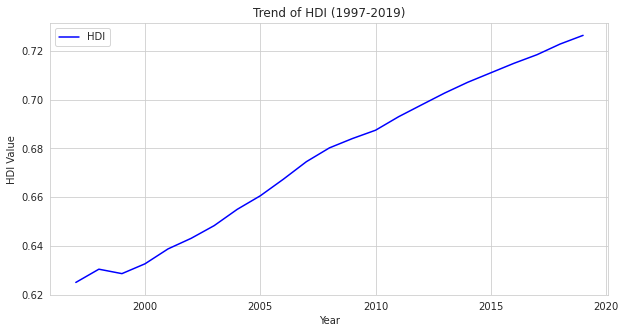

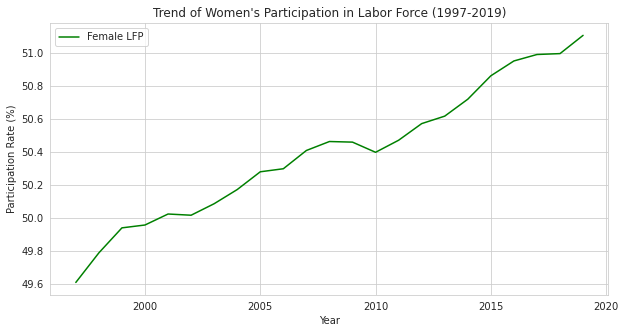

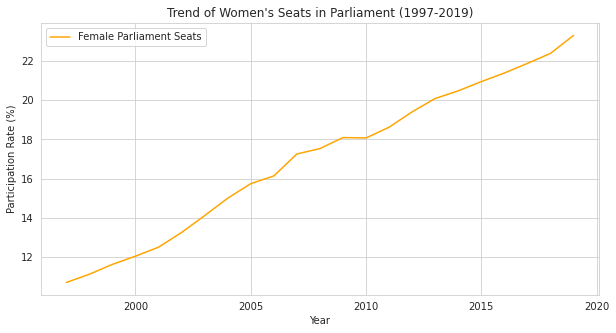

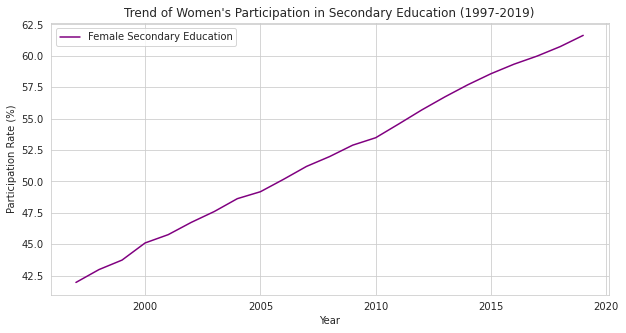

In [29]:

# 2. Convert to Pandas
pdf_grouped = grouped_data.toPandas()

# 3. Plot the data
plt.figure(figsize=(10, 5))
plt.plot(pdf_grouped['Year'], pdf_grouped['avg_hdi'], label='HDI', color='blue')
plt.title('Trend of HDI (1997-2019)')
plt.xlabel('Year')
plt.ylabel('HDI Value')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(pdf_grouped['Year'], pdf_grouped['avg_lfpr_f'], label='Female LFP', color='green')
plt.title('Trend of Women\'s Participation in Labor Force (1997-2019)')
plt.xlabel('Year')
plt.ylabel('Participation Rate (%)')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(pdf_grouped['Year'], pdf_grouped['avg_seat_rate'], label='Female Parliament Seats', color='orange')
plt.title('Trend of Women\'s Seats in Parliament (1997-2019)')
plt.xlabel('Year')
plt.ylabel('Participation Rate (%)')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(pdf_grouped['Year'], pdf_grouped['avg_se_f'], label='Female Secondary Education', color='purple')
plt.title('Trend of Women\'s Participation in Secondary Education (1997-2019)')
plt.xlabel('Year')
plt.ylabel('Participation Rate (%)')
plt.grid(True)
plt.legend()
plt.show()


In [31]:
for column in ['lfpr_f', 'seat_rate', 'se_f']:
    mean_value = merged_data.agg({column: 'mean'}).collect()[0][0]
    merged_data = merged_data.na.fill({column: mean_value})

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# for the first objective: 1.	The correlation between HDI and women's participation in politics, economy, and education;
# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=['lfpr_f', 'seat_rate', 'se_f'], outputCol='features')
assembled_data = assembler.transform(merged_data)

# Splitting the dataset into training and testing sets
train_data, test_data = assembled_data.randomSplit([0.75, 0.25], seed=42)

print("Training set size for first objective:", train_data.count())
print("Testing set size for first objective:", test_data.count())






Training set size for first objective: 3508
Testing set size for first objective: 1105


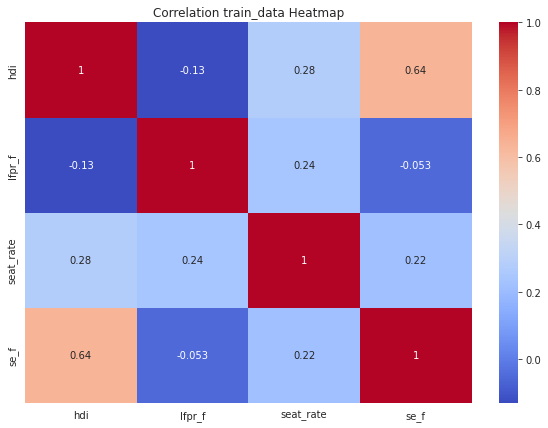

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


features = ['hdi', 'lfpr_f', 'seat_rate', 'se_f']  # replace with your actual features
corr_matrix = []

for feature1 in features:
    row = []
    for feature2 in features:
        corr_value = train_data.stat.corr(feature1, feature2)
        row.append(corr_value)
    corr_matrix.append(row)

# Convert to Pandas DataFrame
corr_df = pd.DataFrame(corr_matrix, index=features, columns=features)

# Plot
plt.figure(figsize=(10, 7))
sns.heatmap(corr_df, annot=True, cmap='coolwarm')
plt.title("Correlation train_data Heatmap")
plt.show()



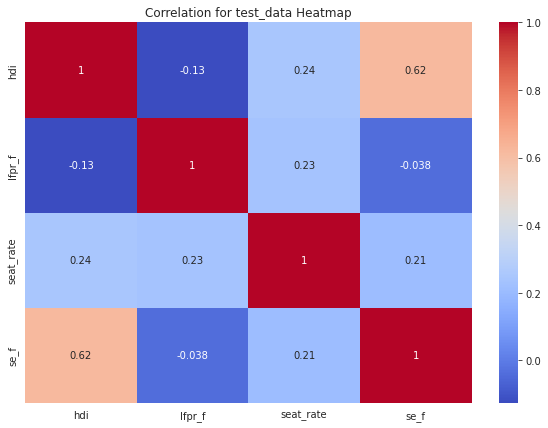

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


features = ['hdi', 'lfpr_f', 'seat_rate', 'se_f']  # replace with your actual features
corr_matrix = []

for feature1 in features:
    row = []
    for feature2 in features:
        corr_value = test_data.stat.corr(feature1, feature2)
        row.append(corr_value)
    corr_matrix.append(row)

# Convert to Pandas DataFrame
corr_df = pd.DataFrame(corr_matrix, index=features, columns=features)

# Plot
plt.figure(figsize=(10, 7))
sns.heatmap(corr_df, annot=True, cmap='coolwarm')
plt.title("Correlation for test_data Heatmap")
plt.show()

In [34]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import mean

from pyspark.sql.types import StringType, DateType

# Filter only numeric columns
numeric_cols = [f.name for f in merged_data.schema.fields if not isinstance(f.dataType, (StringType, DateType))]

# Fill null values only for numeric columns
for col_name in numeric_cols:
    mean_value = merged_data.agg(mean(col_name)).first()[0]
    merged_data = merged_data.na.fill({col_name: mean_value})


# for the second objective: 2.	The correlation between women's participation in the economic, educational, and political fields;
# Splitting the data into train and test
train_data, test_data = merged_data.randomSplit([0.75, 0.25], seed=42)

# For the target 'hdi' (First Objective)
input_cols1 = ['lfpr_f',  'se_f' ,'seat_rate']
assembler1 = VectorAssembler(inputCols=input_cols1, outputCol="features")
train_data1 = assembler1.transform(train_data)
test_data1 = assembler1.transform(test_data)

# Linear Regression
lr1 = LinearRegression(featuresCol='features', labelCol='hdi')
model1 = lr1.fit(train_data1)
train_result1 = model1.evaluate(train_data1)
test_result1 = model1.evaluate(test_data1)

print("Training R2 for target 'hdi':", train_result1.r2)
print("Testing R2 for target 'hdi':", test_result1.r2)

# For the target 'lfpr_f' (Second Objective)
input_cols2 = ['seat_rate', 'se_f']
assembler2 = VectorAssembler(inputCols=input_cols2, outputCol="features")
train_data2 = assembler2.transform(train_data)
test_data2 = assembler2.transform(test_data)

# Linear Regression
lr2 = LinearRegression(featuresCol='features', labelCol='lfpr_f')
model2 = lr2.fit(train_data2)
train_result2 = model2.evaluate(train_data2)
test_result2 = model2.evaluate(test_data2)

print("\nTraining R2 for target 'lfpr_f':", train_result2.r2)
print("Testing R2 for target 'lfpr_f':", test_result2.r2)



23/10/11 05:42:30 WARN Instrumentation: [d25af167] regParam is zero, which might cause numerical instability and overfitting.
23/10/11 05:42:30 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Training R2 for target 'hdi': 0.7052517593982421
Testing R2 for target 'hdi': 0.6952848064036232


23/10/11 05:42:32 WARN Instrumentation: [47903d60] regParam is zero, which might cause numerical instability and overfitting.



Training R2 for target 'lfpr_f': 0.06895063787675593
Testing R2 for target 'lfpr_f': 0.060762012769444484


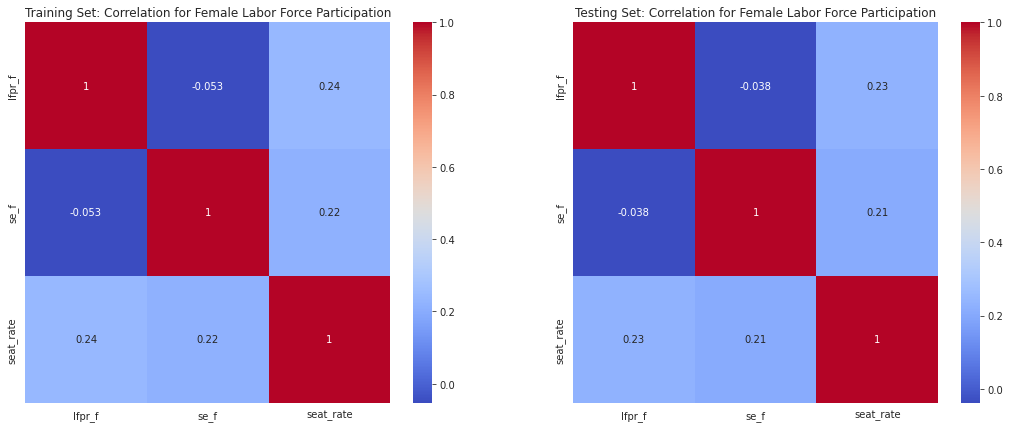

In [35]:
# Correlation for Testing Set
corr_matrix_test = []
for col1 in input_cols1:
    row = []
    for col2 in input_cols1:
        corr_value = test_data.stat.corr(col1, col2)
        row.append(corr_value)
    corr_matrix_test.append(row)

    corr_matrix_train = []
for col1 in input_cols1:
    row = []
    for col2 in input_cols1:
        corr_value = train_data.stat.corr(col1, col2)
        row.append(corr_value)
    corr_matrix_train.append(row)

# Convert to Pandas for visualization
corr_df_train = pd.DataFrame(corr_matrix_train, columns=input_cols1, index=input_cols1)
corr_df_test = pd.DataFrame(corr_matrix_test, columns=input_cols1, index=input_cols1)

# Plotting 1
plt.figure(figsize=(18, 7))
plt.subplot(1, 2, 1)
sns.heatmap(corr_df_train, annot=True, cmap="coolwarm")
plt.title("Training Set: Correlation for Female Labor Force Participation")

plt.subplot(1, 2, 2)
sns.heatmap(corr_df_test, annot=True, cmap="coolwarm")
plt.title("Testing Set: Correlation for Female Labor Force Participation")
plt.show()


In [36]:
# For the target 'seat_rate'
input_cols3 = ['lfpr_f', 'se_f']
assembler3 = VectorAssembler(inputCols=input_cols3, outputCol="features")
train_data3 = assembler3.transform(train_data)
test_data3 = assembler3.transform(test_data)

# Linear Regression
lr3 = LinearRegression(featuresCol='features', labelCol='seat_rate')
model3 = lr3.fit(train_data3)
train_result3 = model3.evaluate(train_data3)
test_result3 = model3.evaluate(test_data3)

print("\nTraining R2 for target 'seat_rate':", train_result3.r2)
print("Testing R2 for target 'seat_rate':", test_result3.r2)

# For the target 'se_f'
input_cols4 = ['lfpr_f', 'seat_rate']
assembler4 = VectorAssembler(inputCols=input_cols4, outputCol="features")
train_data4 = assembler4.transform(train_data)
test_data4 = assembler4.transform(test_data)

# Linear Regression
lr4 = LinearRegression(featuresCol='features', labelCol='se_f')
model4 = lr4.fit(train_data4)
train_result4 = model4.evaluate(train_data4)
test_result4 = model4.evaluate(test_data4)

print("\nTraining R2 for target 'se_f':", train_result4.r2)
print("Testing R2 for target 'se_f':", test_result4.r2)


23/10/11 05:42:41 WARN Instrumentation: [5645dd78] regParam is zero, which might cause numerical instability and overfitting.



Training R2 for target 'seat_rate': 0.10990127580279707
Testing R2 for target 'seat_rate': 0.10085959934667044


23/10/11 05:42:43 WARN Instrumentation: [2debdd93] regParam is zero, which might cause numerical instability and overfitting.



Training R2 for target 'se_f': 0.05835184409368188
Testing R2 for target 'se_f': 0.05016932664685714


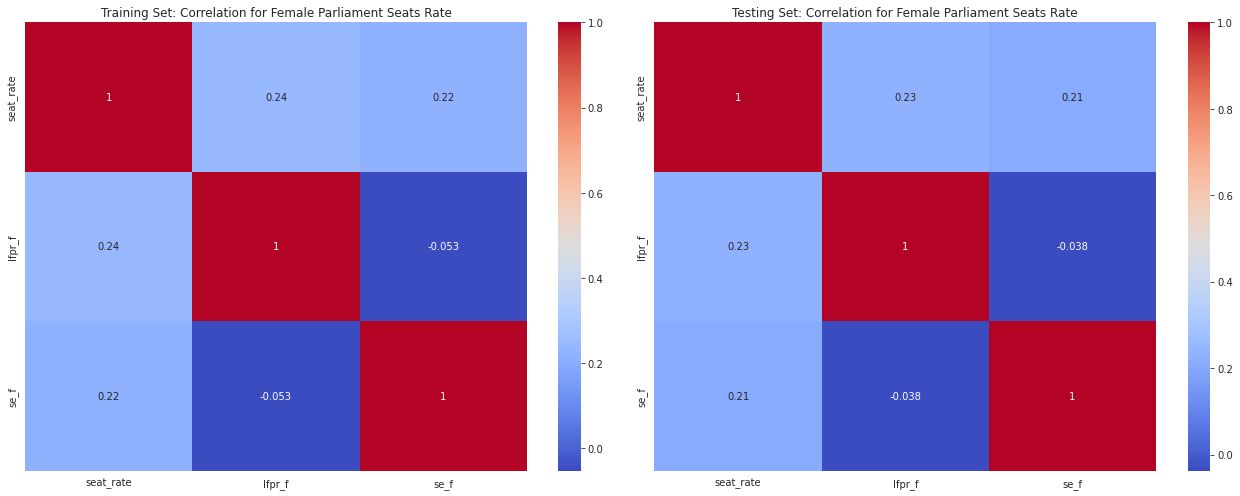

In [37]:
# Define a function to compute the correlation matrix
def compute_correlation_matrix(data, features, target):
    matrix = []
    for feature in [target] + features:
        row = [data.stat.corr(feature, col) for col in [target] + features]
        matrix.append(row)
    return pd.DataFrame(matrix, index=[target] + features, columns=[target] + features)

# Compute correlation matrices for the training and testing data
corr_matrix_train3 = compute_correlation_matrix(train_data3, input_cols3, 'seat_rate')
corr_matrix_test3 = compute_correlation_matrix(test_data3, input_cols3, 'seat_rate')

corr_matrix_train4 = compute_correlation_matrix(train_data4, input_cols4, 'se_f')
corr_matrix_test4 = compute_correlation_matrix(test_data4, input_cols4, 'se_f')

# Plot heatmaps
plt.figure(figsize=(18, 7))

# Heatmap for Training set with target 'seat_rate'
plt.subplot(1, 2, 1)
sns.heatmap(corr_matrix_train3, annot=True, cmap="coolwarm")
plt.title("Training Set: Correlation for Female Parliament Seats Rate")

# Heatmap for Testing set with target 'seat_rate'
plt.subplot(1, 2, 2)
sns.heatmap(corr_matrix_test3, annot=True, cmap="coolwarm")
plt.title("Testing Set: Correlation for Female Parliament Seats Rate")



plt.tight_layout()
plt.show()


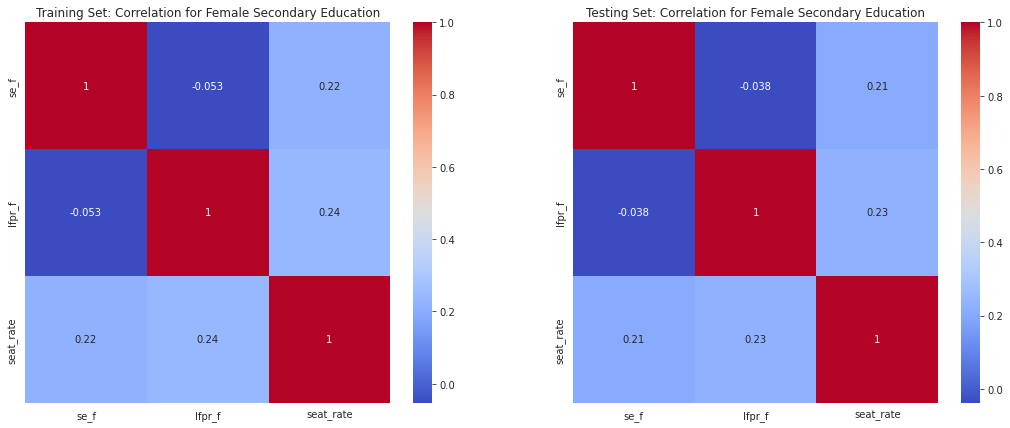

In [38]:
# Heatmap for Training set with target 'se_f'
plt.figure(figsize=(18, 7))
plt.subplot(1, 2, 1)
sns.heatmap(corr_matrix_train4, annot=True, cmap="coolwarm")
plt.title("Training Set: Correlation for Female Secondary Education")

# Heatmap for Testing set with target 'se_f'
plt.subplot(1, 2, 2)
sns.heatmap(corr_matrix_test4, annot=True, cmap="coolwarm")
plt.title("Testing Set: Correlation for Female Secondary Education")
plt.show()



In [39]:
from pyspark.sql import functions as F
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
# Split the data into training and test sets (75% training, 25% test)
train_data, test_data = merged_data.randomSplit([0.75, 0.25], seed=42)


# Filter data for years 1997 to 2019
train_filtered = train_data.filter((train_data["Year"] >= 1997) & (train_data["Year"] <= 2019))
test_filtered = test_data.filter((test_data["Year"] >= 1997) & (test_data["Year"] <= 2019))

# Group by Year and compute averages
train_grouped = train_filtered.groupBy("Year").agg(F.mean('se_f').alias('se_f'), F.mean('lfpr_f').alias('lfpr_f'), F.mean('seat_rate').alias('seat_rate'), F.mean('hdi').alias('hdi'))
test_grouped = test_filtered.groupBy("Year").agg(F.mean('se_f').alias('se_f'), F.mean('lfpr_f').alias('lfpr_f'), F.mean('seat_rate').alias('seat_rate'), F.mean('hdi').alias('hdi'))



In [40]:
assembler = VectorAssembler(inputCols=["Year"], outputCol="features")
train_assembled = assembler.transform(train_grouped)
test_assembled = assembler.transform(test_grouped)
results = {}

# List of columns to predict
columns_to_predict = ["se_f", "lfpr_f", "seat_rate", "hdi"]

for column in columns_to_predict:
    # Train the model
    lr = LinearRegression(featuresCol='features', labelCol=column)
    model = lr.fit(train_assembled)
    
    # Make predictions
    train_predictions = model.transform(train_assembled)
    test_predictions = model.transform(test_assembled)

    # Evaluate the model
    evaluator = RegressionEvaluator(labelCol=column, metricName="r2")
    
    train_score = evaluator.evaluate(train_predictions)
    test_score = evaluator.evaluate(test_predictions)
    
    # Store the results
    results[column] = {"train_score": train_score, "test_score": test_score}






23/10/11 05:42:58 WARN Instrumentation: [76d8f3f3] regParam is zero, which might cause numerical instability and overfitting.
23/10/11 05:43:00 WARN Instrumentation: [5925725a] regParam is zero, which might cause numerical instability and overfitting.
23/10/11 05:43:02 WARN Instrumentation: [7acc75fd] regParam is zero, which might cause numerical instability and overfitting.
23/10/11 05:43:04 WARN Instrumentation: [8db8d43f] regParam is zero, which might cause numerical instability and overfitting.


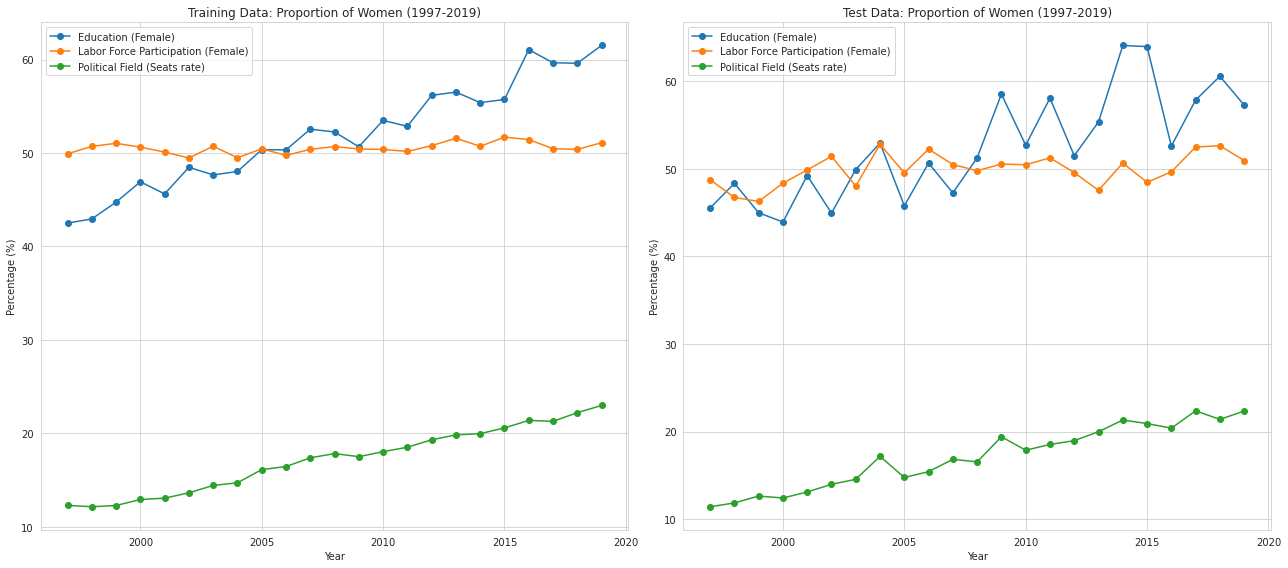

In [41]:
import matplotlib.pyplot as plt

# Extract data for visualization
years = [row['Year'] for row in train_grouped.select('Year').orderBy("Year").collect()]
train_se_f = [row['se_f'] for row in train_grouped.select('se_f').orderBy("Year").collect()]
test_se_f = [row['se_f'] for row in test_grouped.select('se_f').orderBy("Year").collect()]
train_lfpr_f = [row['lfpr_f'] for row in train_grouped.select('lfpr_f').orderBy("Year").collect()]
test_lfpr_f = [row['lfpr_f'] for row in test_grouped.select('lfpr_f').orderBy("Year").collect()]
train_seat_rate = [row['seat_rate'] for row in train_grouped.select('seat_rate').orderBy("Year").collect()]
test_seat_rate = [row['seat_rate'] for row in test_grouped.select('seat_rate').orderBy("Year").collect()]

plt.figure(figsize=(18, 8))

# Plotting the proportions for training data
plt.subplot(1, 2, 1)
plt.plot(years, train_se_f, label="Education (Female)", marker='o')
plt.plot(years, train_lfpr_f, label="Labor Force Participation (Female)", marker='o')
plt.plot(years, train_seat_rate, label="Political Field (Seats rate)", marker='o')
plt.title("Training Data: Proportion of Women (1997-2019)")
plt.xlabel("Year")
plt.ylabel("Percentage (%)")
plt.legend()
plt.grid(True)

# Plotting the proportions for test data
plt.subplot(1, 2, 2)
plt.plot(years, test_se_f, label="Education (Female)", marker='o')
plt.plot(years, test_lfpr_f, label="Labor Force Participation (Female)", marker='o')
plt.plot(years, test_seat_rate, label="Political Field (Seats rate)", marker='o')
plt.title("Test Data: Proportion of Women (1997-2019)")
plt.xlabel("Year")
plt.ylabel("Percentage (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



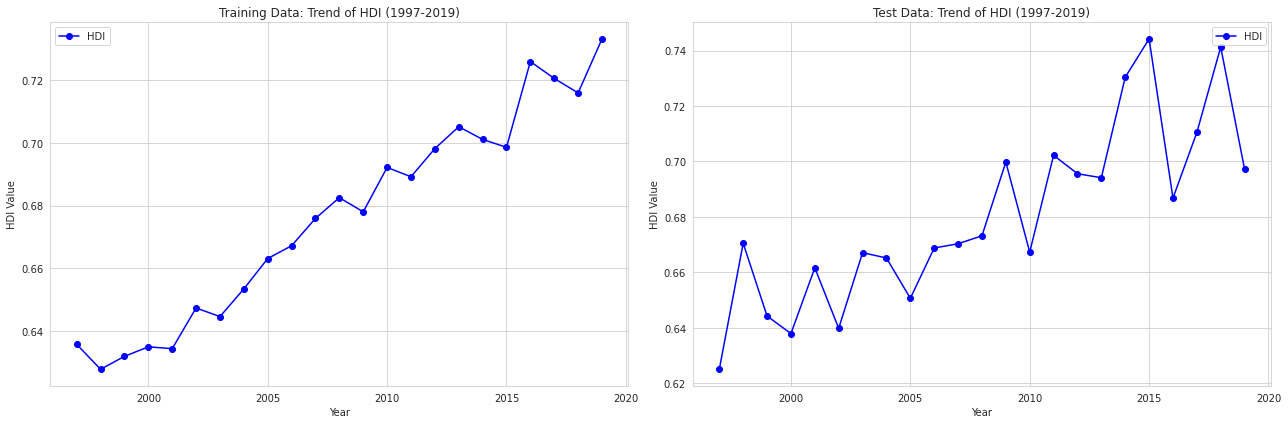

In [42]:
train_hdi = [row['hdi'] for row in train_grouped.select('hdi').orderBy("Year").collect()]
test_hdi = [row['hdi'] for row in test_grouped.select('hdi').orderBy("Year").collect()]

plt.figure(figsize=(18, 6))

# Plotting HDI trend for training data
plt.subplot(1, 2, 1)
plt.plot(years, train_hdi, label="HDI", color='blue', marker='o')
plt.title("Training Data: Trend of HDI (1997-2019)")
plt.xlabel("Year")
plt.ylabel("HDI Value")
plt.legend()
plt.grid(True)

# Plotting HDI trend for test data
plt.subplot(1, 2, 2)
plt.plot(years, test_hdi, label="HDI", color='blue', marker='o')
plt.title("Test Data: Trend of HDI (1997-2019)")
plt.xlabel("Year")
plt.ylabel("HDI Value")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


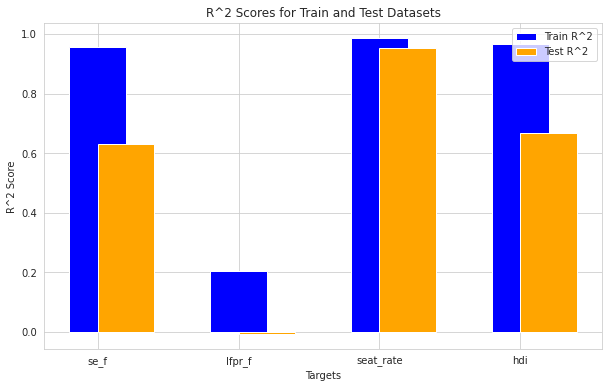

In [43]:
labels = list(results.keys())
train_scores = [results[column]["train_score"] for column in labels]
test_scores = [results[column]["test_score"] for column in labels]

x = range(len(labels))

plt.figure(figsize=(10, 6))
plt.bar(x, train_scores, width=0.4, label='Train R^2', color='blue', align='center')
plt.bar(x, test_scores, width=0.4, label='Test R^2', color='orange', align='edge')
plt.xlabel('Targets')
plt.ylabel('R^2 Score')
plt.title('R^2 Scores for Train and Test Datasets')
plt.xticks(x, labels)
plt.legend()
plt.grid(True, axis='y')

plt.show()


In [44]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Assemble features into a single vector column
assembler_prop = VectorAssembler(inputCols=["Year"], outputCol="features")

train_assembled_prop = assembler_prop.transform(train_grouped)
test_assembled_prop = assembler_prop.transform(test_grouped)

# Modeling and scoring for the "Proportion of Women (1997-2019)"
lr_prop = LinearRegression(featuresCol="features", labelCol="se_f")
model_se_f = lr_prop.fit(train_assembled_prop)
evaluator = RegressionEvaluator(labelCol="se_f", metricName="r2")

train_score_se_f = evaluator.evaluate(model_se_f.transform(train_assembled_prop))
test_score_se_f = evaluator.evaluate(model_se_f.transform(test_assembled_prop))

# You can repeat the above steps for 'lfpr_f' and 'seat_rate' columns

# Modeling and scoring for the "Trend of HDI (1997-2019)"
lr_hdi = LinearRegression(featuresCol="features", labelCol="hdi")
model_hdi = lr_hdi.fit(train_assembled_prop)

evaluator_hdi = RegressionEvaluator(labelCol="hdi", metricName="r2")

train_score_hdi = evaluator_hdi.evaluate(model_hdi.transform(train_assembled_prop))
test_score_hdi = evaluator_hdi.evaluate(model_hdi.transform(test_assembled_prop))

train_score_se_f, test_score_se_f, train_score_hdi, test_score_hdi


23/10/11 05:43:12 WARN Instrumentation: [7a3294a1] regParam is zero, which might cause numerical instability and overfitting.
23/10/11 05:43:14 WARN Instrumentation: [d5abfef5] regParam is zero, which might cause numerical instability and overfitting.


(0.9570993936578915,
 0.6300832890395609,
 0.9668252386515275,
 0.6669792372961292)

In [45]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

# Convert Year column to double type for modeling
train_grouped = train_grouped.withColumn("Year", train_grouped["Year"].cast("double"))

# Assemble features
assembler = VectorAssembler(inputCols=["Year"], outputCol="features")
train_grouped_assembled = assembler.transform(train_grouped)

# Function to compute coefficients
def compute_coefficient(target_col):
    lr = LinearRegression(featuresCol="features", labelCol=target_col)
    model = lr.fit(train_grouped_assembled)
    return model.coefficients[0]





In [46]:
coeff_se_f = compute_coefficient("se_f")
coeff_lfpr_f = compute_coefficient("lfpr_f")
coeff_seat_rate = compute_coefficient("seat_rate")

print('Coefficients:')
print('se_f: ' + str(coeff_se_f))
print('lfpr_f: ' + str(coeff_lfpr_f))
print('seat_rate: ' + str(coeff_seat_rate))


23/10/11 05:43:25 WARN Instrumentation: [9e2e4afb] regParam is zero, which might cause numerical instability and overfitting.
23/10/11 05:43:27 WARN Instrumentation: [20d76dde] regParam is zero, which might cause numerical instability and overfitting.
23/10/11 05:43:28 WARN Instrumentation: [e15723e4] regParam is zero, which might cause numerical instability and overfitting.


Coefficients:
se_f: 0.8143373762615402
lfpr_f: 0.039251765696709434
seat_rate: 0.507442614358588


In [47]:
# Calculate correlation with year
corr_se_f_with_time = train_grouped.stat.corr("Year", "se_f")
corr_lfpr_f_with_time = train_grouped.stat.corr("Year", "lfpr_f")
corr_seat_rate_with_time = train_grouped.stat.corr("Year", "seat_rate")
corr_hdi_with_time = train_grouped.stat.corr("Year", "hdi")

print('\nCorrelation with Year:')
print('hdi: ' + str(corr_hdi_with_time))
print('se_f: ' + str(corr_se_f_with_time))
print('lfpr_f: ' + str(corr_lfpr_f_with_time))
print('seat_rate: ' + str(corr_seat_rate_with_time))



Correlation with Year:
hdi: 0.9832727183500671
se_f: 0.9783145678450733
lfpr_f: 0.450211599354164
seat_rate: 0.9939941810789115


In [48]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Assembling features
assembler = VectorAssembler(inputCols=['seat_rate', 'lfpr_f', 'se_f'], outputCol='features')
train_assembled = assembler.transform(train_grouped)
test_assembled = assembler.transform(test_grouped)

# Standardizing the features
scaler = StandardScaler(inputCol="features", outputCol="std_features", withStd=True, withMean=True)
scaler_model = scaler.fit(train_assembled)
train_standardized = scaler_model.transform(train_assembled)
test_standardized = scaler_model.transform(test_assembled)

# Linear regression with standardized features
lr_std = LinearRegression(featuresCol='std_features', labelCol='hdi')
model_std = lr_std.fit(train_standardized)
train_r2_std = model_std.summary.r2
test_r2_std = model_std.evaluate(test_standardized).r2

print("Training R2 with standardization:", train_r2_std)
print("Test R2 with standardization:", test_r2_std)

# Linear regression without standardization
lr = LinearRegression(featuresCol='features', labelCol='hdi')
model = lr.fit(train_assembled)
train_r2 = model.summary.r2
test_r2 = model.evaluate(test_assembled).r2

print("\nTraining R2 without standardization:", train_r2)
print("Test R2 without standardization:", test_r2)

# Predictor importance
predictor_importance_std = dict(zip(['seat_rate', 'lfpr_f', 'se_f'], model_std.coefficients))
predictor_importance = dict(zip(['seat_rate', 'lfpr_f', 'se_f'], model.coefficients))

predictor_names = ['seat_rate', 'lfpr_f', 'se_f']
coefficients = list(model_std.coefficients)  
importance=list( model.coefficients)  

print("\nPredictor importance with standardization-seat_rate:", coefficients[0])
print("\nPredictor importance with standardization-lfpr_f:", coefficients[1])
print("\nPredictor importance with standardization-se_f:", coefficients[2])
print("Predictor importance :", predictor_importance)


23/10/11 05:43:31 WARN Instrumentation: [807b8e13] regParam is zero, which might cause numerical instability and overfitting.


Training R2 with standardization: 0.9843446578520599
Test R2 with standardization: 0.8348098321195621


23/10/11 05:43:33 WARN Instrumentation: [38c2d9ad] regParam is zero, which might cause numerical instability and overfitting.



Training R2 without standardization: 0.9843446578520599
Test R2 without standardization: 0.8348098321194768

Predictor importance with standardization-seat_rate: 0.022293570838445166

Predictor importance with standardization-lfpr_f: -0.0004509743667057882

Predictor importance with standardization-se_f: 0.010967986998880463
Predictor importance : {'seat_rate': 0.006438691644394009, 'lfpr_f': -0.0007626590424553981, 'se_f': 0.0019427734657934638}


In [49]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# 1. Use VectorAssembler to merge feature columns
assembler = VectorAssembler(
    inputCols=['lfpr_f', 'seat_rate', 'se_f'],
    outputCol="features")
data_with_features = assembler.transform(merged_data)


train_data, test_data = data_with_features.randomSplit([0.75, 0.25], seed=42)

# 3. Use decision tree regression model for training
tree_model = DecisionTreeRegressor(featuresCol="features", labelCol="hdi", seed=42)
tree_model_fitted = tree_model.fit(train_data)

# 4. Make predictions on training and test data
train_predictions = tree_model_fitted.transform(train_data)
test_predictions = tree_model_fitted.transform(test_data)

# 5. Use RegressionEvaluator to calculate MSE and R^2 to evaluate the model
evaluator_mse = RegressionEvaluator(labelCol="hdi", predictionCol="prediction", metricName="mse")
evaluator_r2 = RegressionEvaluator(labelCol="hdi", predictionCol="prediction", metricName="r2")

train_mse = evaluator_mse.evaluate(train_predictions)
test_mse = evaluator_mse.evaluate(test_predictions)
train_r2 = evaluator_r2.evaluate(train_predictions)
test_r2 = evaluator_r2.evaluate(test_predictions)

(train_mse, test_mse, train_r2, test_r2)



(0.004887928451293058,
 0.0052521893441202115,
 0.8036671238994249,
 0.7804325995435495)

In [50]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

# 定义特征向量并为数据集组装特征
assembler = VectorAssembler(inputCols=['seat_rate', 'se_f'], outputCol="features")
data = assembler.transform(merged_data)

# Splitting the data into training and test sets
train_data, test_data = data.randomSplit([0.75, 0.25], seed=42)

# Training a decision tree model for 'lfpr_f'
tree_model_lfpr = DecisionTreeRegressor(featuresCol="features", labelCol="lfpr_f", seed=42)
model_lfpr = tree_model_lfpr.fit(train_data)

# Making predictions
predictions_train = model_lfpr.transform(train_data)
predictions_test = model_lfpr.transform(test_data)

# Evaluating the model
evaluator = RegressionEvaluator(labelCol="lfpr_f", predictionCol="prediction", metricName="mse")
train_mse_lfpr = evaluator.evaluate(predictions_train)
test_mse_lfpr = evaluator.evaluate(predictions_test)

evaluator_r2 = RegressionEvaluator(labelCol="lfpr_f", predictionCol="prediction", metricName="r2")
train_r2_lfpr = evaluator_r2.evaluate(predictions_train)
test_r2_lfpr = evaluator_r2.evaluate(predictions_test)

print('Train MSE for lfpr_f:', train_mse_lfpr)
print('Test MSE for lfpr_f:', test_mse_lfpr)
print('Train R2 for lfpr_f:', train_r2_lfpr)
print('Test R2 for lfpr_f:', test_r2_lfpr)


Train MSE for lfpr_f: 196.09904811935021
Test MSE for lfpr_f: 218.36544492820147
Train R2 for lfpr_f: 0.23110498419455772
Test R2 for lfpr_f: 0.13548265212837451


In [51]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Assembling vector for 'Female Secondary Education'
assembler_edu = VectorAssembler(inputCols=['seat_rate', 'lfpr_f'], outputCol='features')
data_vectorized_edu = assembler_edu.transform(merged_data)

# Splitting the data for 'Female Secondary Education'
train_data_edu, test_data_edu = data_vectorized_edu.randomSplit([0.75, 0.25], seed=42)

# Training a decision tree model for 'Female Secondary Education'
tree_model_edu = DecisionTreeRegressor(featuresCol='features', labelCol='se_f', seed=42)
model_edu = tree_model_edu.fit(train_data_edu)

# Making predictions
predictions_train_edu = model_edu.transform(train_data_edu)
predictions_test_edu = model_edu.transform(test_data_edu)

# Evaluating the model
evaluator_mse = RegressionEvaluator(labelCol="se_f", predictionCol="prediction", metricName="mse")
evaluator_r2 = RegressionEvaluator(labelCol="se_f", predictionCol="prediction", metricName="r2")

train_mse_edu = evaluator_mse.evaluate(predictions_train_edu)
test_mse_edu = evaluator_mse.evaluate(predictions_test_edu)
train_r2_edu = evaluator_r2.evaluate(predictions_train_edu)
test_r2_edu = evaluator_r2.evaluate(predictions_test_edu)

print('Train MSE for se_f:', train_mse_edu)
print('Test MSE for se_f:', test_mse_edu)
print('Train R2 for se_f:', train_r2_edu)
print('Test R2 for se_f:', test_r2_edu)


Train MSE for se_f: 496.9001107414337
Test MSE for se_f: 532.5912196253358
Train R2 for se_f: 0.3681096373981799
Test R2 for se_f: 0.2986283081497817
